In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import matplotlib.pyplot as plt
import os
import anndata
import harmonypy as hm
import seaborn as sns
import scrublet as scr
import bbknn as bk
%matplotlib inline

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sc.settings.set_figure_params(dpi=300,fontsize=10)

In [5]:
adata = sc.read_h5ad("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Test/Test2_nolog/bin50_A1-1.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 9416 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
adata.obs['arterial_ec'] = (adata.X[:,adata.var_names=='GJA5'] > 1) & (adata.X[:,adata.var_names=='VWF'] > 1)

In [8]:
adata_aec = adata[adata.obs['arterial_ec'] == True]

In [9]:
adata_aec

View of AnnData object with n_obs × n_vars = 68 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
data = adata_aec.obs[['X_coor','Y_coor']]
linkage_data = linkage(data, method='average', metric='euclidean')

In [11]:
temp = dendrogram(linkage_data,no_plot=True)

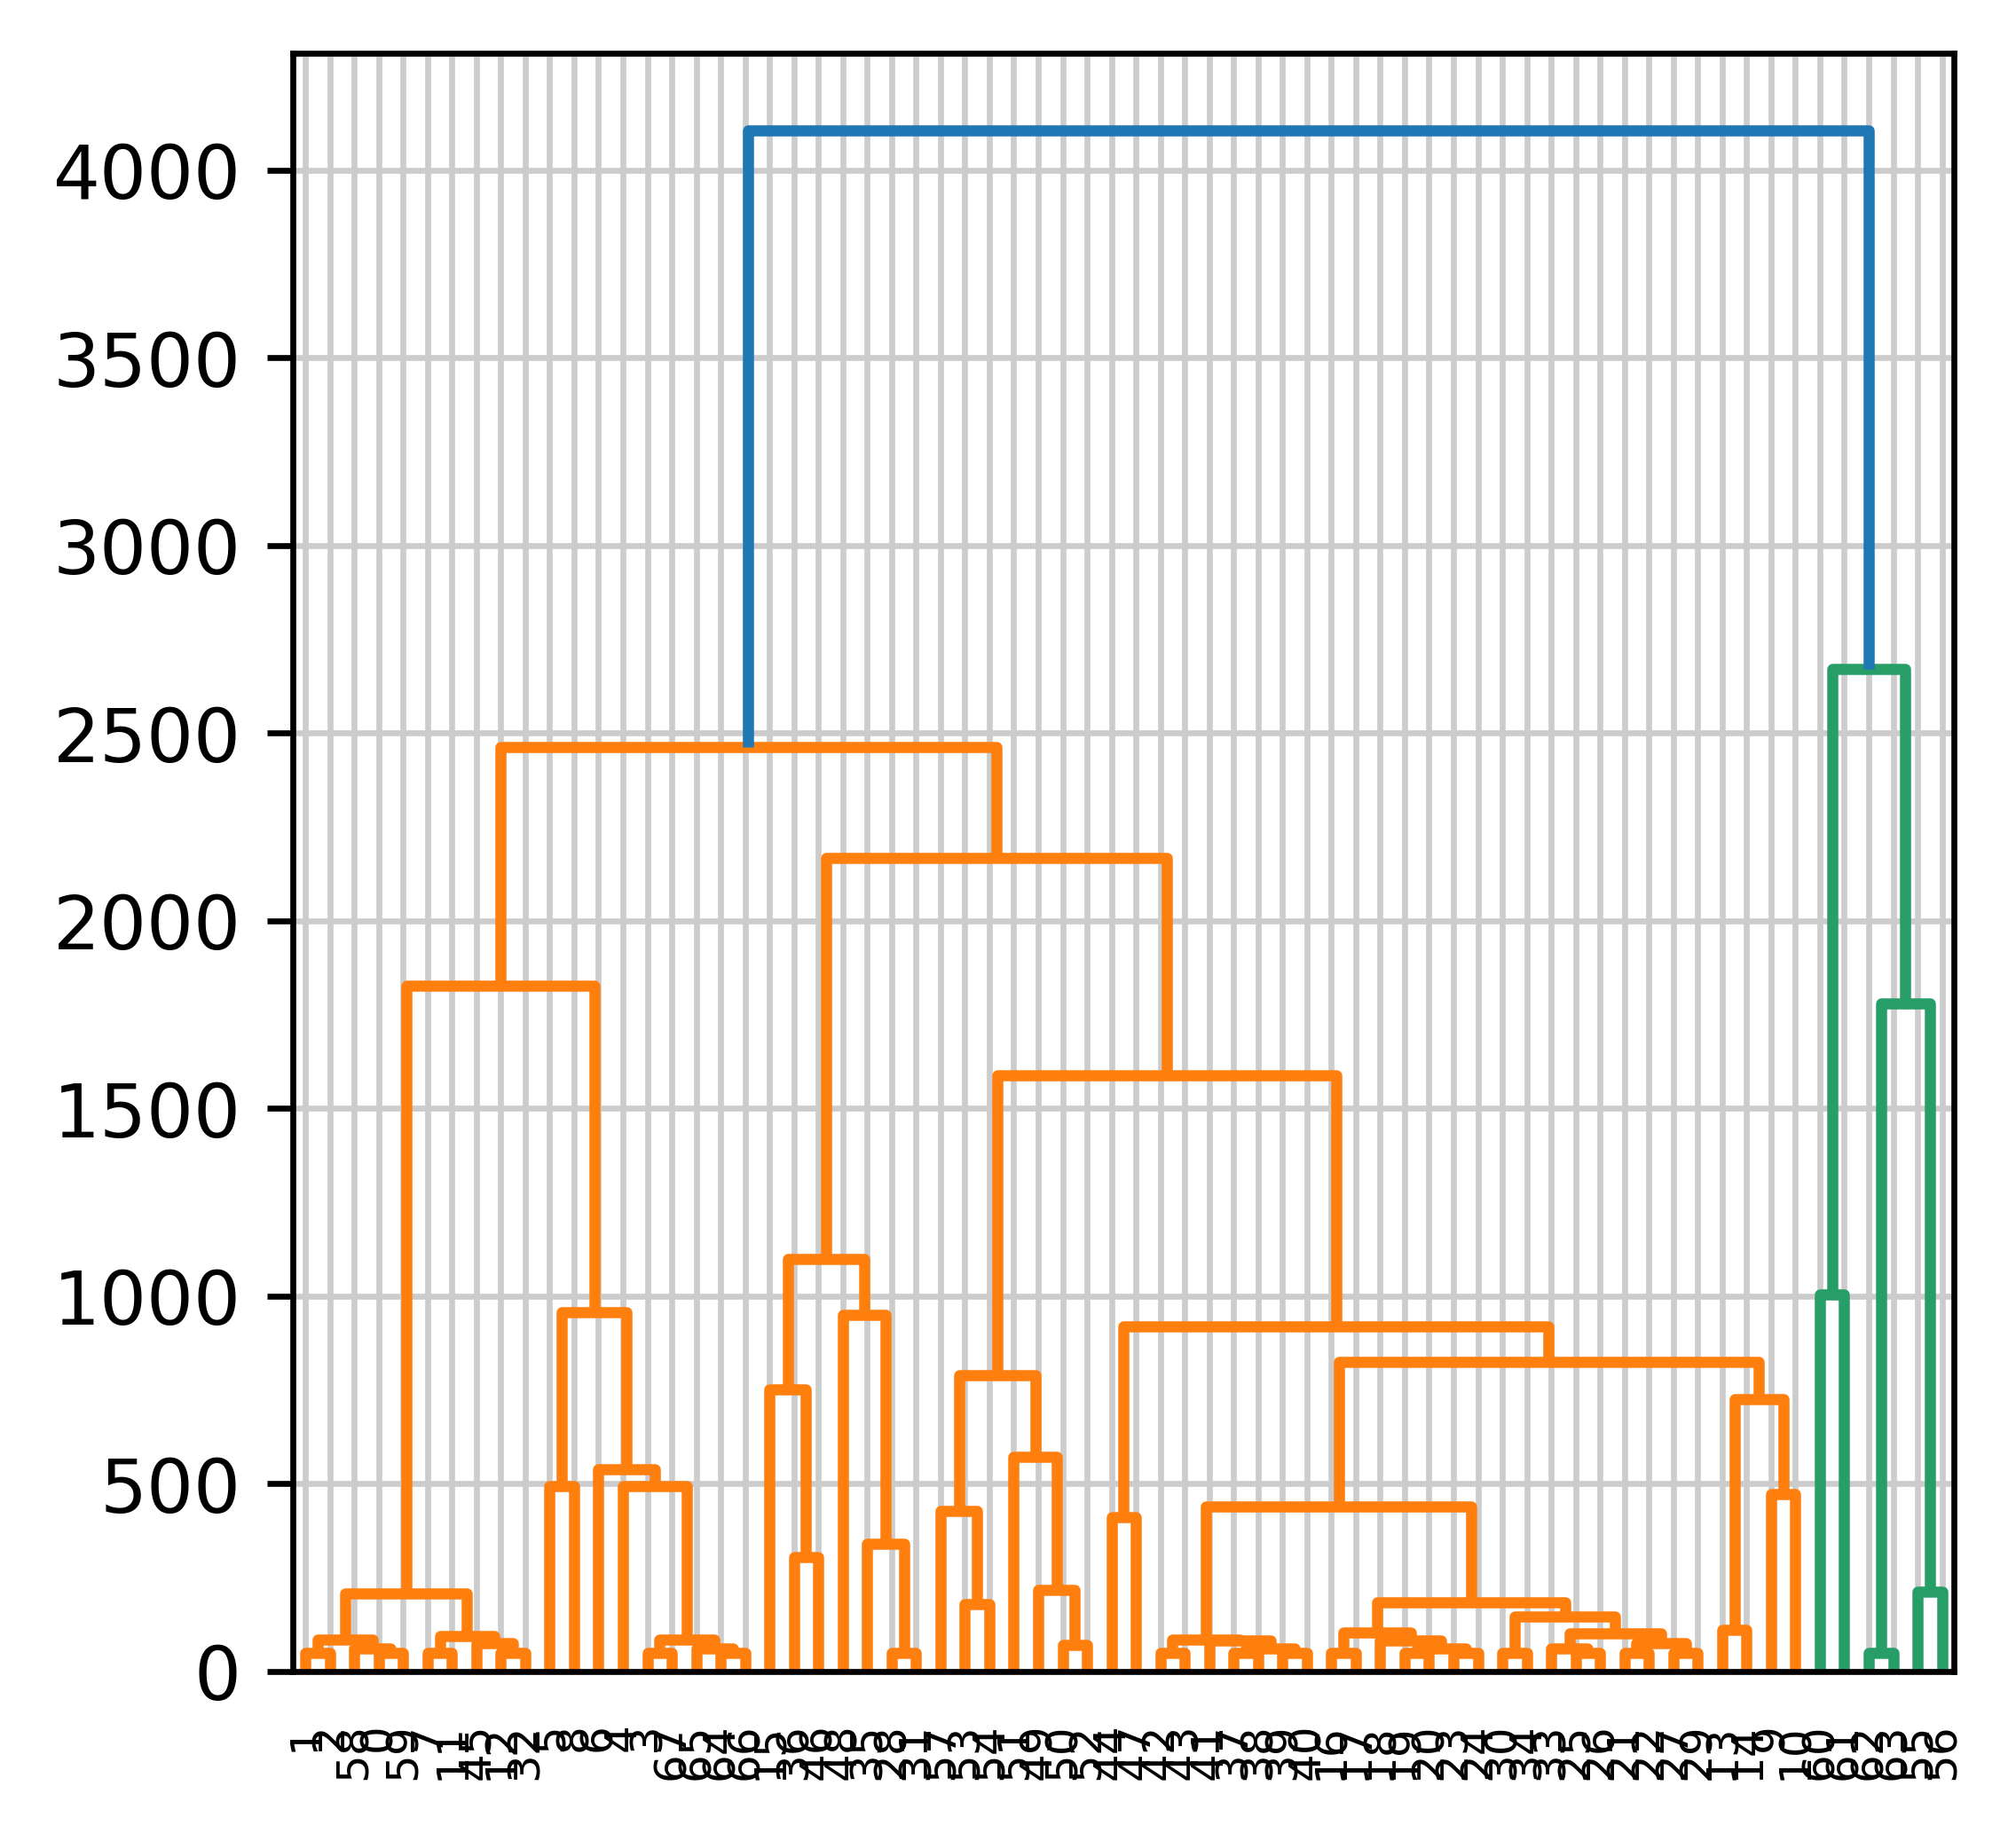

In [12]:
dendrogram(linkage_data)
plt.show()

In [13]:
# adjust n_clusters to relevant number of vessels
hierarchical_cluster = AgglomerativeClustering(n_clusters=30, affinity='euclidean', linkage='single')

In [14]:
labels = hierarchical_cluster.fit_predict(data) 
print(labels)

[ 1  1  1 11 21 17 20  1 15 29 19  1  1  0  0 23 12 12 12 12 12 12 12 12
 12 12 12 12  4 12 12  4  1 12 12 24 25  5  5  5  5  5  5  5 22  1 18 10
  8 28  2 16  2 14 27 13  7  6  1  1 26  9  3  3 11 11 11 11]


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [15]:
adata_aec.obs['Artery_clusters'] = labels
adata_aec.obs['Artery_clusters'] = adata_aec.obs['Artery_clusters'].astype('category')

/var/tmp/pbs.8217755.pbs/ipykernel_3385140/2590496195.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_aec.obs['Artery_clusters'] = labels
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [16]:
adata_aec.obs['Artery_clusters'].value_counts()

12    16
1     10
5      7
11     5
0      2
2      2
3      2
4      2
21     1
22     1
23     1
25     1
24     1
19     1
26     1
27     1
28     1
20     1
15     1
18     1
17     1
16     1
14     1
13     1
10     1
9      1
8      1
7      1
6      1
29     1
Name: Artery_clusters, dtype: int64

In [17]:
# subset for clusters > 5 bins
adata_aec.obs['Artery_clusters'].value_counts()[adata_aec.obs['Artery_clusters'].value_counts() > 5].index.tolist()

[12, 1, 5]

In [18]:
adata_aec

AnnData object with n_obs × n_vars = 68 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec', 'Artery_clusters'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [19]:
adata_aec_subset = adata_aec[adata_aec.obs.Artery_clusters.isin(adata_aec.obs['Artery_clusters'].value_counts()[adata_aec.obs['Artery_clusters'].value_counts() > 5].index.tolist())]

In [20]:
adata_aec_subset.obs.Artery_clusters = adata_aec_subset.obs.Artery_clusters.astype(str).astype('category')

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [20]:
#sc.pl.spatial(adata, color=["VWF","GJA5"],img_key='WGA', size=5, vmax = 1, cmap = 'plasma', ncols=2)

In [21]:
#sc.pl.spatial(adata, color=["VWF"],img_key='WGA', size=5, vmax = 1, cmap = 'plasma')

In [22]:
#sc.pl.spatial(adata, color=["GJA5"],img_key='WGA', size=5, vmax = 1, cmap = 'plasma')

genes=["VWF","GJA5"]

genedf=pd.DataFrame(index=adata.obs.index)
for i in genes:
    genedf[i]=np.asarray(pd.DataFrame(adata[:, i].X))

genedf

group=pd.Series("None", index=adata.obs.index)

gene1="VWF"
gene2="GJA5"

group[(genedf[gene1] > 0)] = gene1
group[(genedf[gene2] > 0)] = gene2
group[(genedf[gene1]> 0) & (genedf[gene2] > 0)] = gene1+"/"+gene2

group.replace("None", np.nan, inplace=True) # replace 0 with nan for better plotting down the line
adata.obs["coloc"]=group


group

sc.pl.spatial(adata,color="coloc",img_key="WGA",size=7, palette = 'spring')
sc.pl.spatial(adata,color="coloc",img_key=None,size=7, palette = 'plasma')

sc.pl.spatial(adata,color=["TTN"],img_key=None,cmap="plasma",use_raw=False,vmin=0,size=8)

sc.pl.spatial(adata,
              color="GJA5",img_key='WGA',size=8,
              color_map = 'plasma', na_color = None)

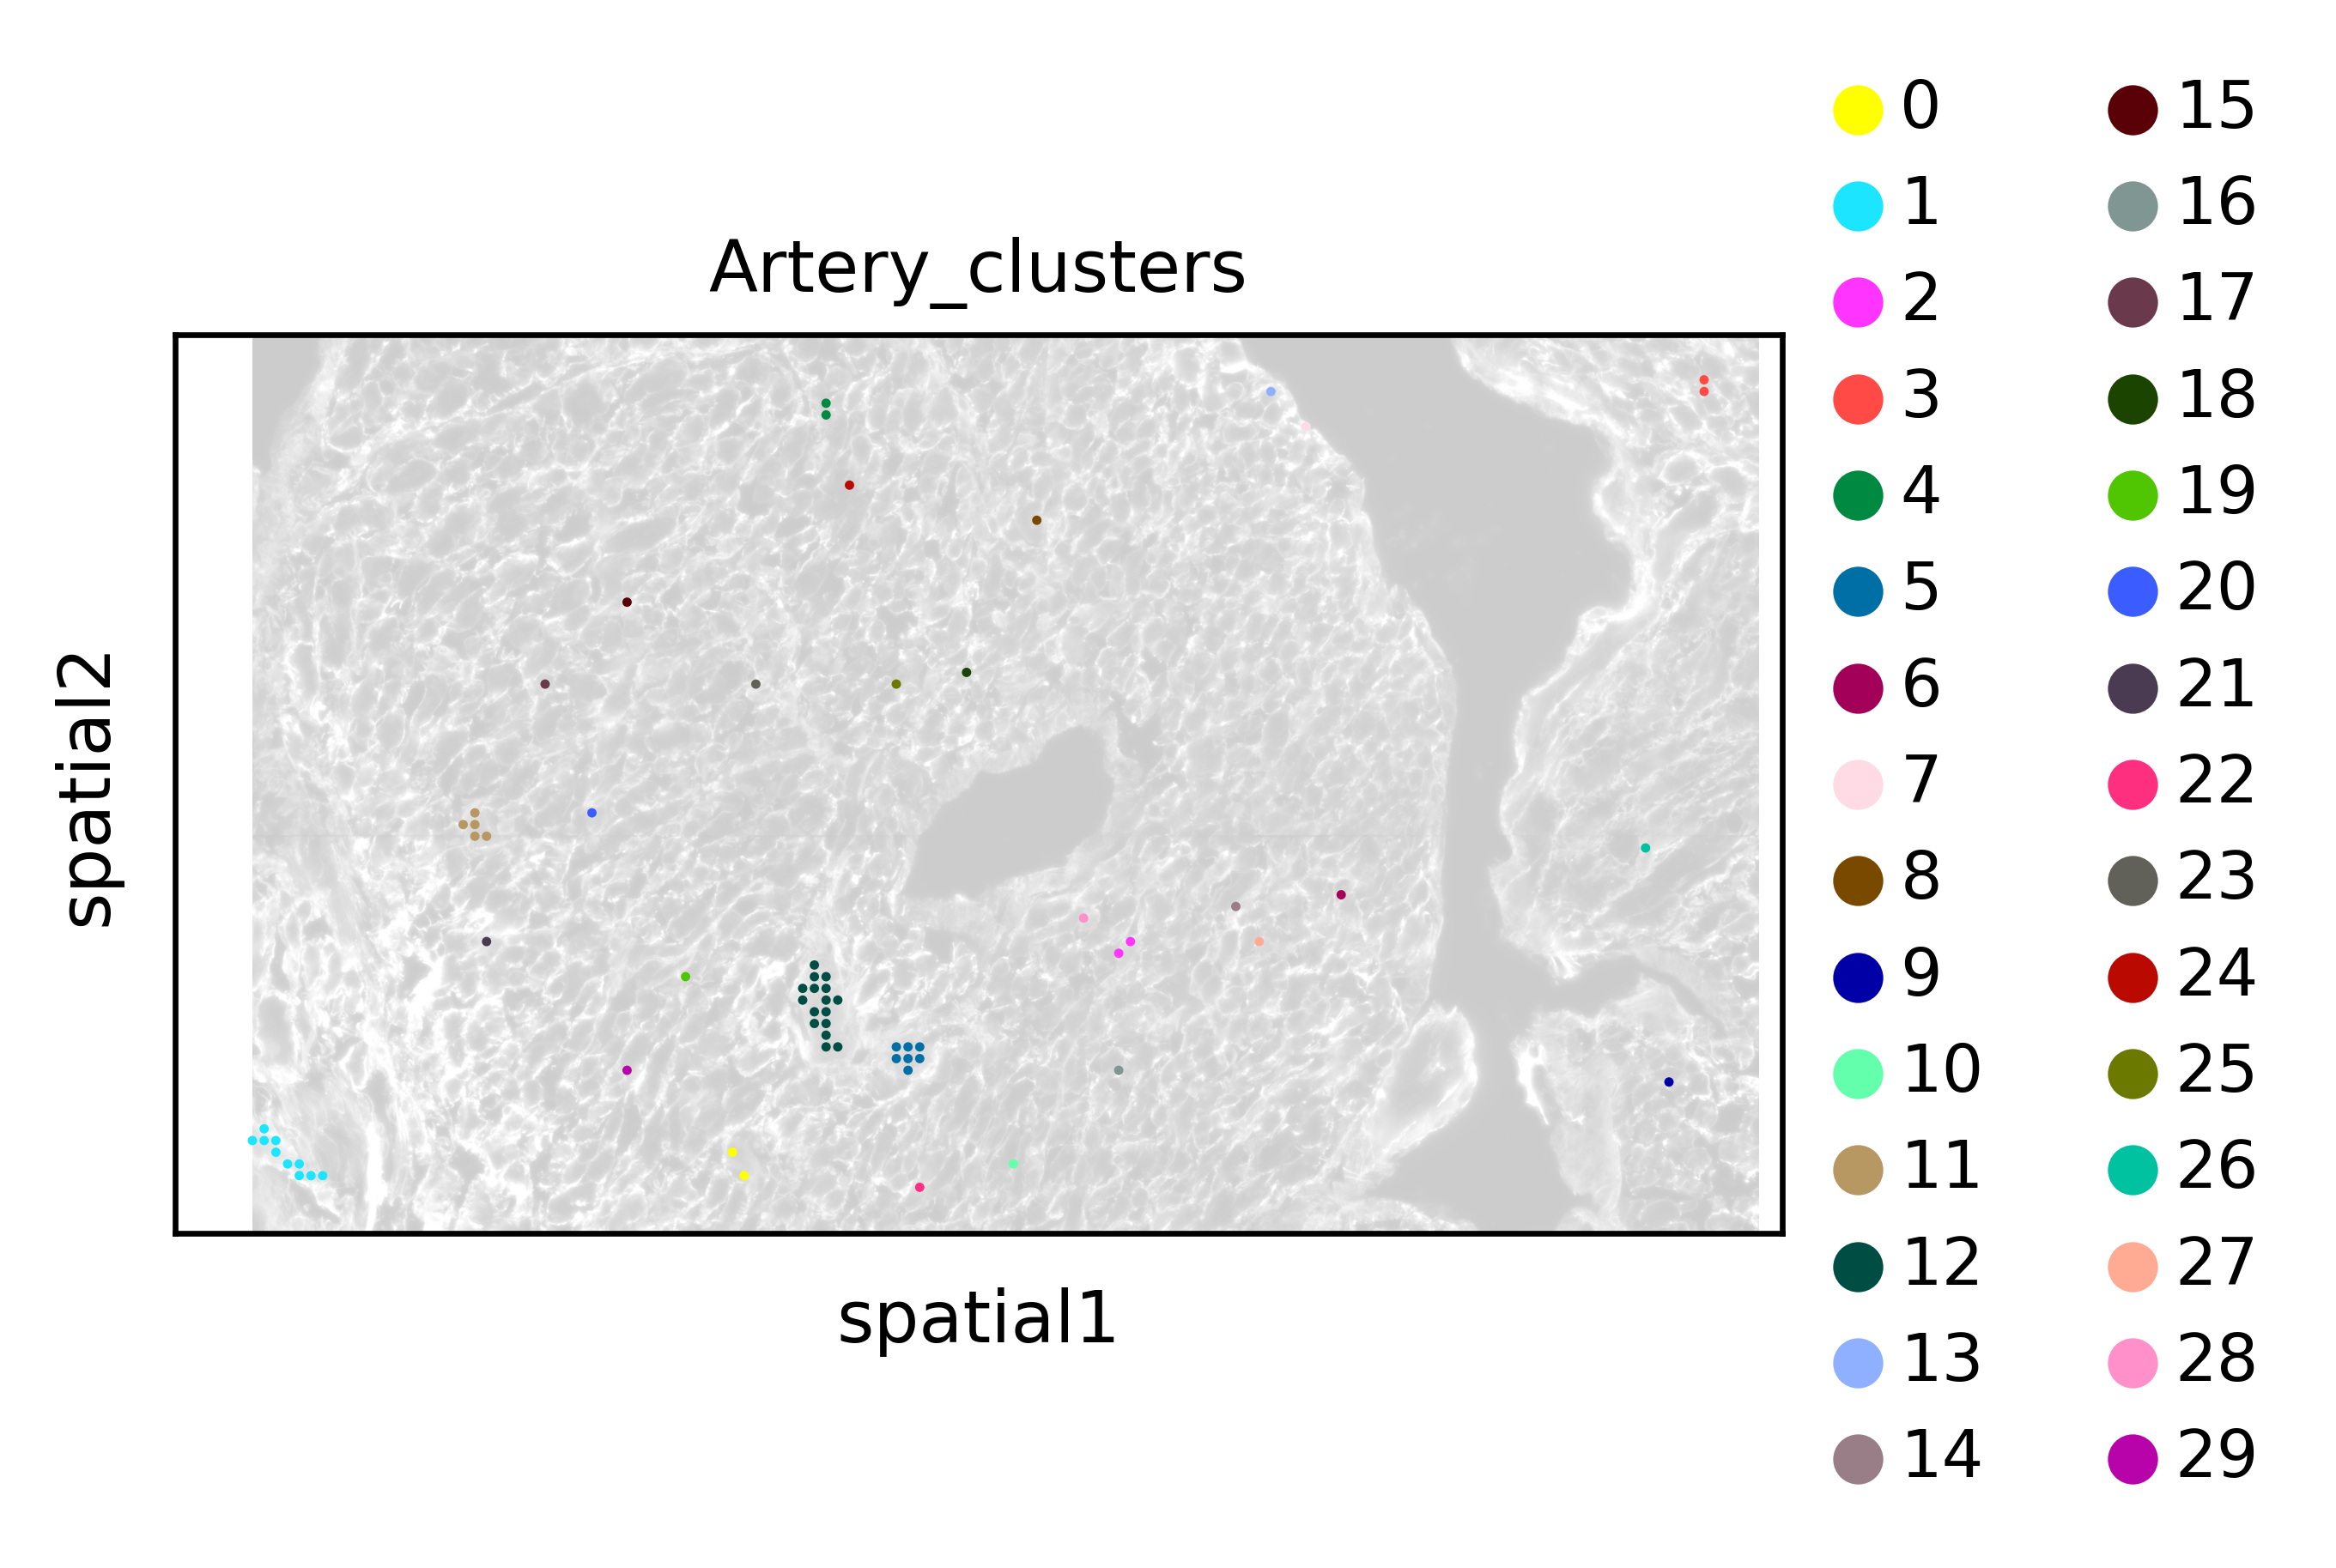

In [23]:
sc.pl.spatial(adata_aec,
              color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

In [24]:
adata_aec_subset

AnnData object with n_obs × n_vars = 33 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec', 'Artery_clusters'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

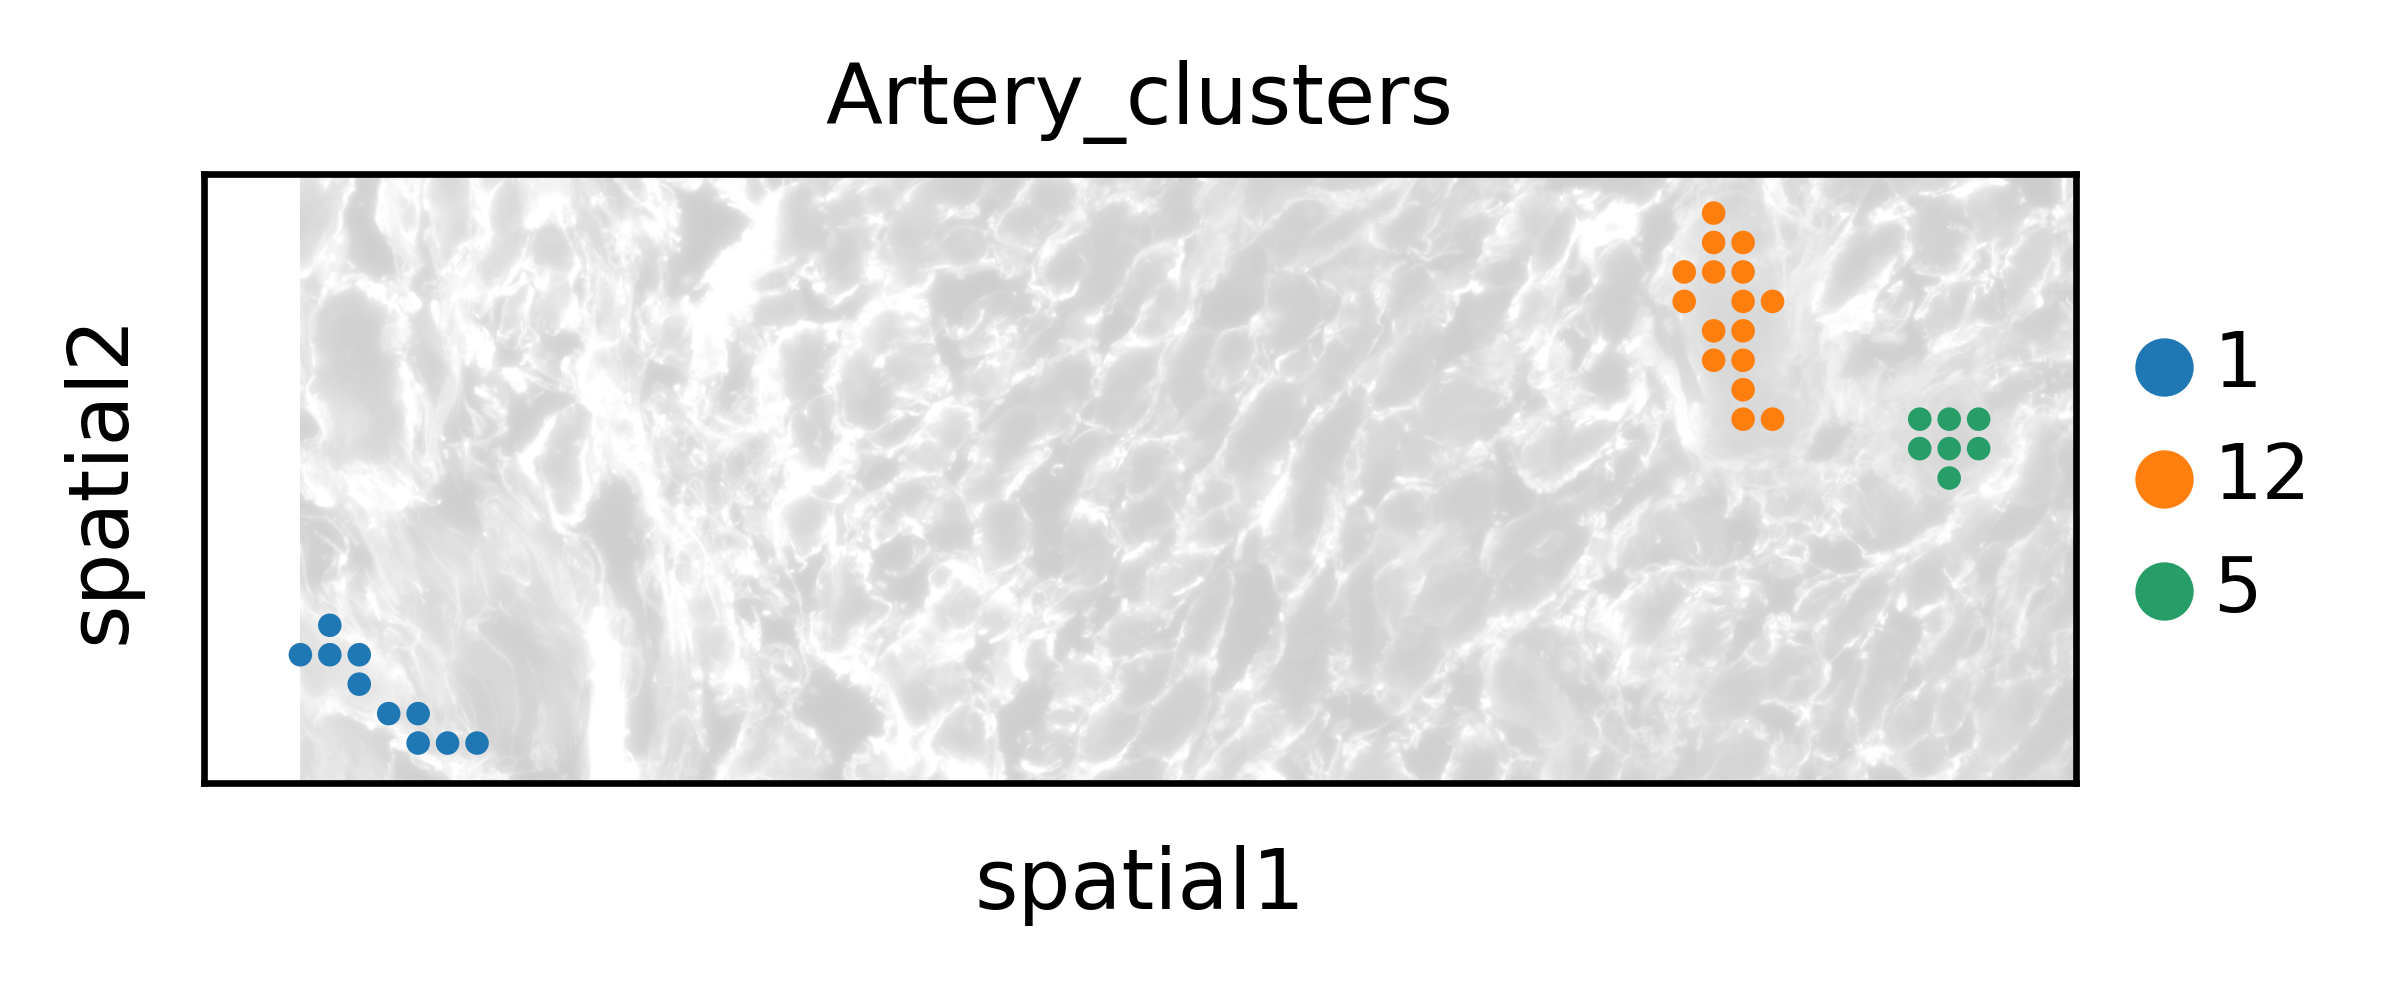

In [25]:
sc.pl.spatial(adata_aec_subset,
              color="Artery_clusters", img_key='WGA',size=8, alpha_img = 0.2)

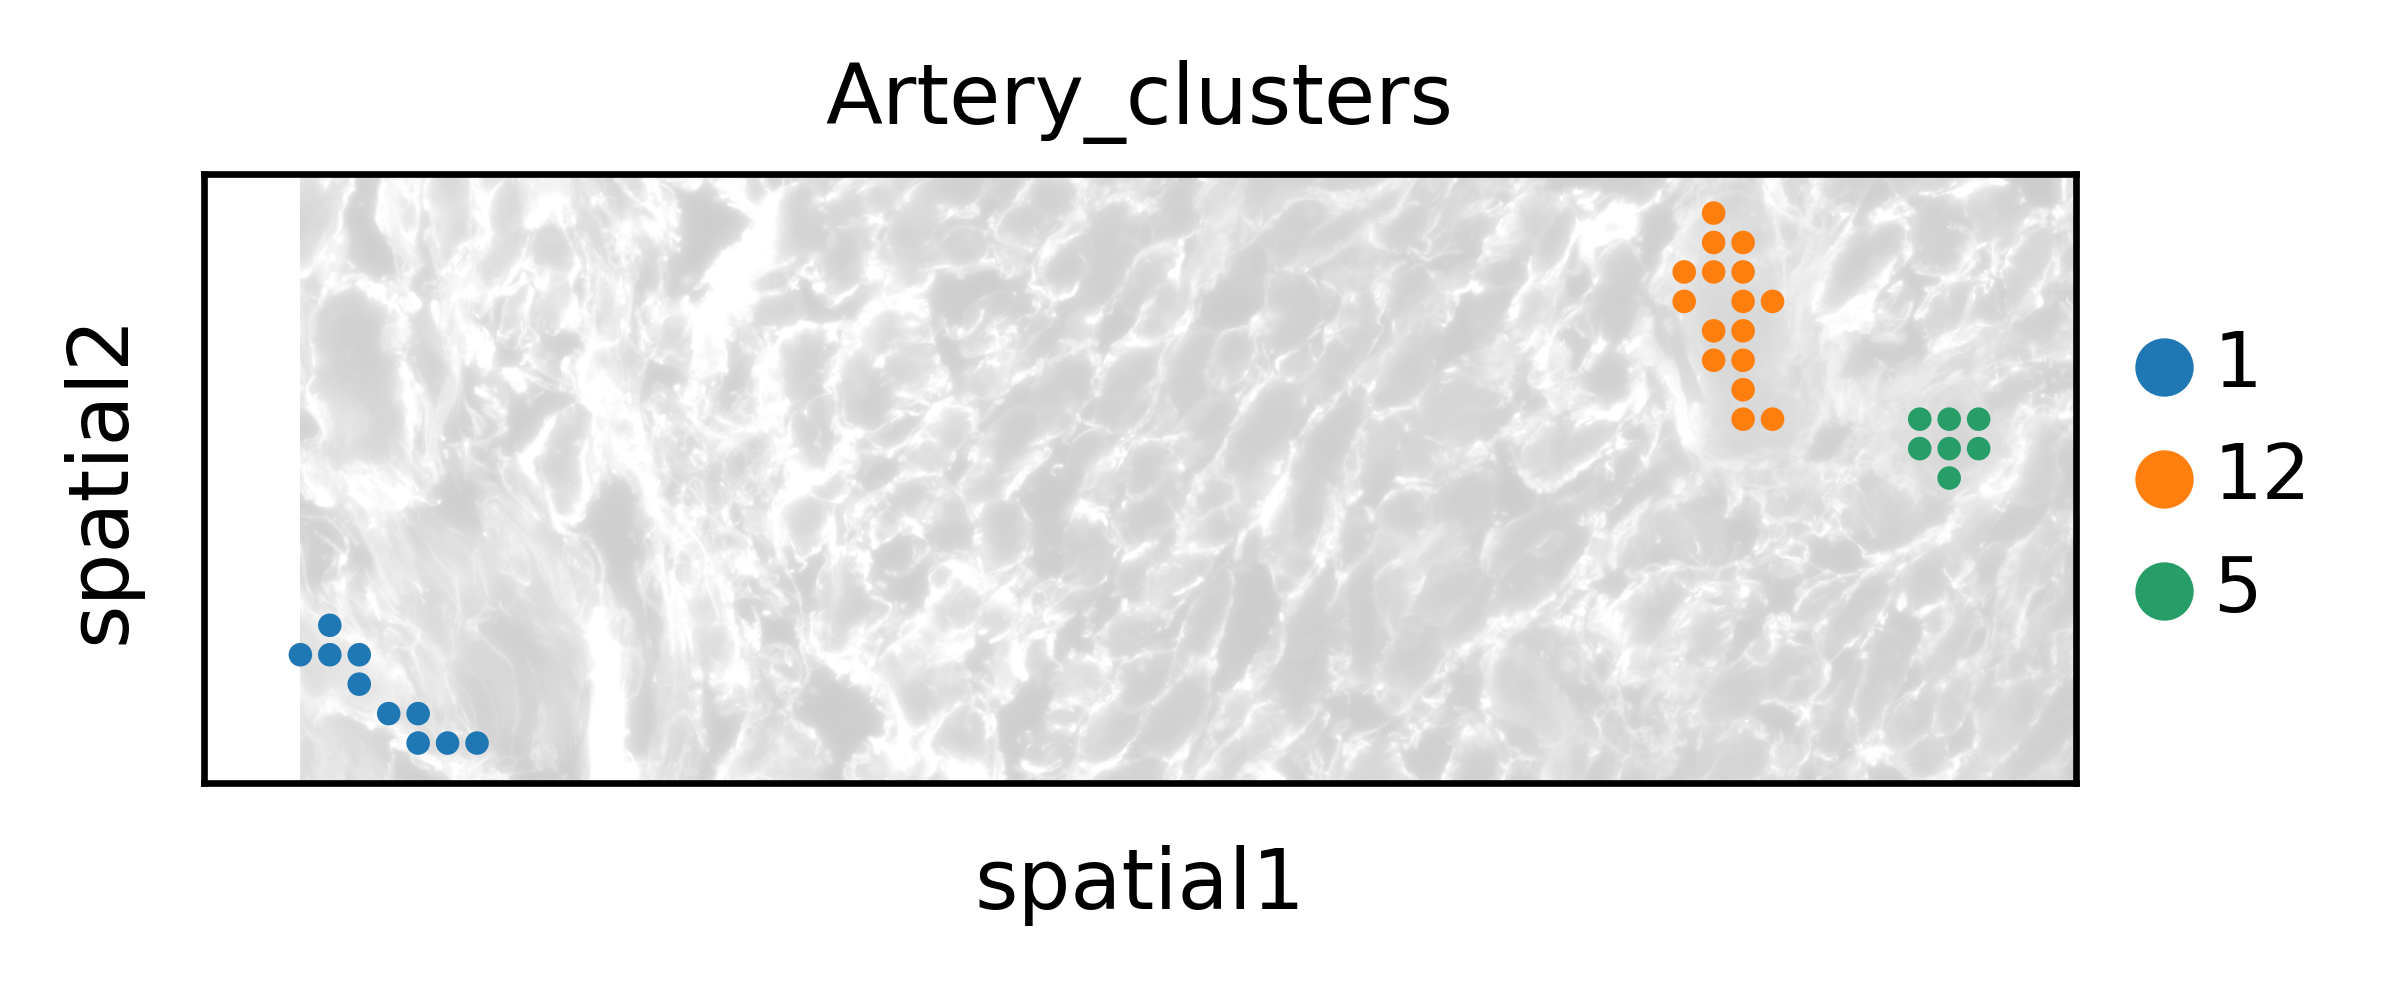

In [26]:
sc.pl.spatial(adata_aec_subset,
              color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

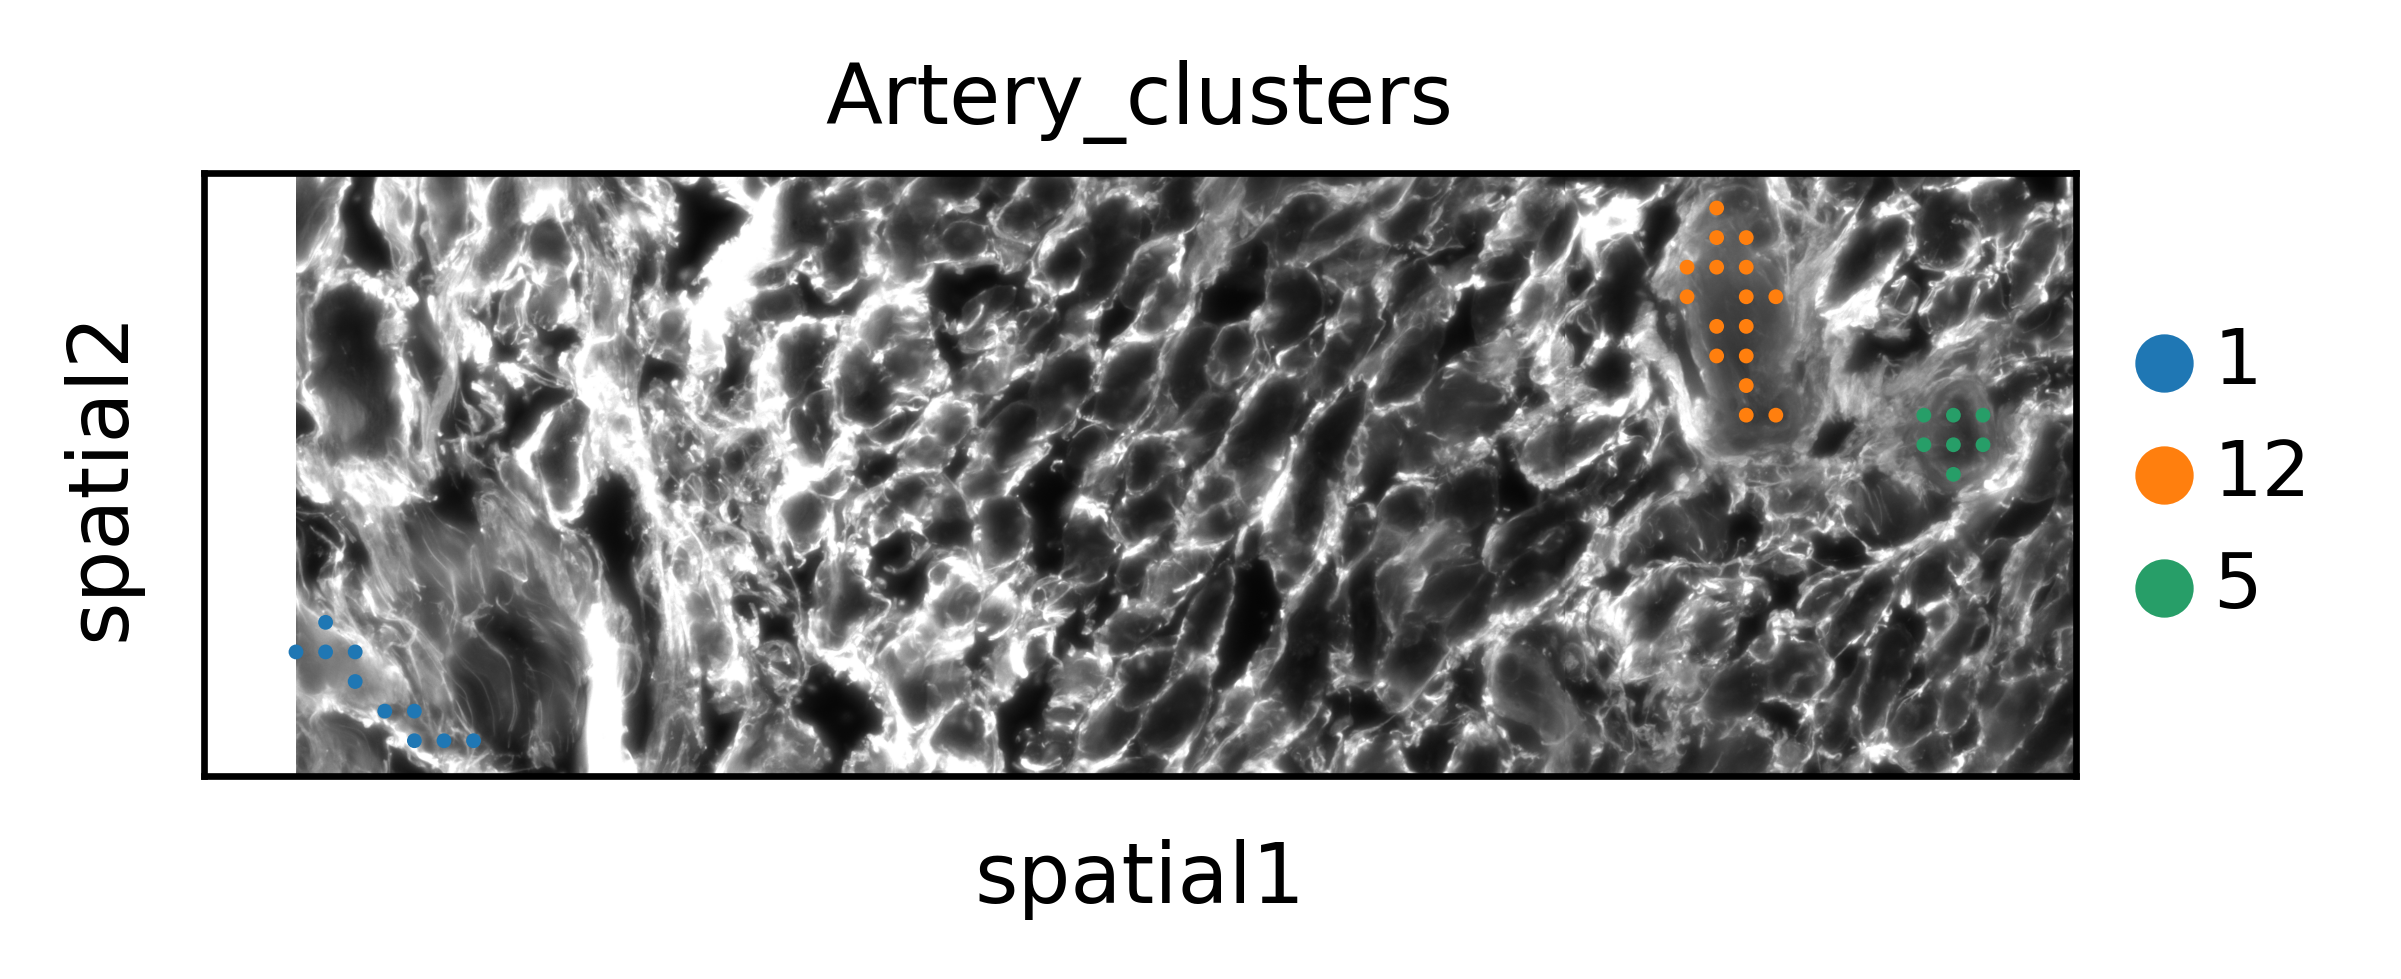

In [27]:
sc.pl.spatial(adata_aec_subset,
              color="Artery_clusters",img_key='WGA',size=5)

### obtain bins percent expressing values

In [21]:
adata_aec_subset.obs['SULF1_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SULF1'] > 0)

In [22]:
adata_aec_subset.obs['NEBL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='NEBL'] > 0)

In [23]:
adata_aec_subset.obs['SEMA3G_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SEMA3G'] > 0)

In [24]:
adata_aec_subset.obs['RGCC_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='RGCC'] > 0)

In [25]:
adata_aec_subset.obs['SULF1+NEBL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SULF1'] > 1) & (adata_aec_subset.X[:,adata_aec_subset.var_names=='NEBL'] > 0)

In [26]:
adata_aec_subset

AnnData object with n_obs × n_vars = 33 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec', 'Artery_clusters', 'SULF1_percent', 'NEBL_percent', 'SEMA3G_percent', 'RGCC_percent', 'SULF1+NEBL_percent'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [27]:
results = adata_aec_subset.obs[['SULF1+NEBL_percent','SULF1_percent','NEBL_percent','SEMA3G_percent','RGCC_percent','Artery_clusters']].groupby('Artery_clusters').mean()

In [28]:
results

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  \
Artery_clusters                                                    
1                               0.0         0.0000      0.300000   
12                              0.0         0.0625      0.312500   
5                               0.0         0.0000      0.428571   

                 SEMA3G_percent  RGCC_percent  
Artery_clusters                                
1                      0.500000        0.5000  
12                     0.812500        0.1875  
5                      0.714286        0.0000

### obtain mean expression (all bins / cluster)

In [29]:
matrix=pd.DataFrame(adata_aec_subset.X,columns=adata_aec_subset.raw.var.index,index=adata_aec_subset.obs.index)

In [30]:
matrix["Artery_clusters"] = adata_aec_subset.obs["Artery_clusters"]

In [31]:
df_mean=matrix.groupby("Artery_clusters").mean()

In [32]:
df_mean[["SULF1","NEBL","SEMA3G","RGCC"]]

Genes             SULF1      NEBL    SEMA3G    RGCC
Artery_clusters                                    
1                0.0000  0.300000  1.100000  0.7000
12               0.0625  0.375000  1.937500  0.1875
5                0.0000  0.428571  1.428571  0.0000

### obtain mean expression (expressing bins only / cluster)

In [33]:
matrix2 = matrix.replace(0, np.NaN)

In [34]:
df_mean_nonzero =matrix2.groupby("Artery_clusters").mean()

In [35]:
df_mean_nonzero[["SULF1","NEBL","SEMA3G","RGCC"]]

Genes            SULF1  NEBL    SEMA3G  RGCC
Artery_clusters                             
1                  NaN   1.0  2.200000   1.4
12                 1.0   1.2  2.384615   1.0
5                  NaN   1.0  2.000000   NaN

### add expression values to dataframe

In [36]:
#mean expression (all bins / cluster)
test = pd.concat([results, df_mean[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [37]:
test

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  \
Artery_clusters                                                    
1                               0.0         0.0000      0.300000   
12                              0.0         0.0625      0.312500   
5                               0.0         0.0000      0.428571   

                 SEMA3G_percent  RGCC_percent   SULF1      NEBL    SEMA3G  \
Artery_clusters                                                             
1                      0.500000        0.5000  0.0000  0.300000  1.100000   
12                     0.812500        0.1875  0.0625  0.375000  1.937500   
5                      0.714286        0.0000  0.0000  0.428571  1.428571   

                   RGCC  
Artery_clusters          
1                0.7000  
12               0.1875  
5                0.0000

In [38]:
#mean expression (expressing bins only / cluster)
test2 = pd.concat([results, df_mean_nonzero[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [39]:
test2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  \
Artery_clusters                                                    
1                               0.0         0.0000      0.300000   
12                              0.0         0.0625      0.312500   
5                               0.0         0.0000      0.428571   

                 SEMA3G_percent  RGCC_percent  SULF1  NEBL    SEMA3G  RGCC  
Artery_clusters                                                             
1                      0.500000        0.5000    NaN   1.0  2.200000   1.4  
12                     0.812500        0.1875    1.0   1.2  2.384615   1.0  
5                      0.714286        0.0000    NaN   1.0  2.000000   NaN

In [64]:
test2.rename(columns={"SULF1": "SULF1_mean", "NEBL": "NEBL_mean", "SEMA3G": "SEMA3G_mean", "RGCC": "RGCC_mean"}, inplace = True)

In [66]:
test2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  \
Artery_clusters                                                    
1                               0.0         0.0000      0.300000   
12                              0.0         0.0625      0.312500   
5                               0.0         0.0000      0.428571   

                 SEMA3G_percent  RGCC_percent  SULF1_mean  NEBL_mean  \
Artery_clusters                                                        
1                      0.500000        0.5000         NaN        1.0   
12                     0.812500        0.1875         1.0        1.2   
5                      0.714286        0.0000         NaN        1.0   

                 SEMA3G_mean  RGCC_mean  
Artery_clusters                          
1                   2.200000        1.4  
12                  2.384615        1.0  
5                   2.000000        NaN

## add raw values

In [67]:
df_sum=matrix.groupby("Artery_clusters").sum()

In [68]:
df_sum[["SULF1","NEBL","SEMA3G","RGCC","GJA5"]]

Genes            SULF1  NEBL  SEMA3G  RGCC  GJA5
Artery_clusters                                 
1                  0.0   3.0    11.0   7.0  37.0
12                 1.0   6.0    31.0   3.0  81.0
5                  0.0   3.0    10.0   0.0  30.0

In [69]:
test3 = pd.concat([test2, df_sum[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [70]:
test3

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  \
Artery_clusters                                                    
1                               0.0         0.0000      0.300000   
12                              0.0         0.0625      0.312500   
5                               0.0         0.0000      0.428571   

                 SEMA3G_percent  RGCC_percent  SULF1_mean  NEBL_mean  \
Artery_clusters                                                        
1                      0.500000        0.5000         NaN        1.0   
12                     0.812500        0.1875         1.0        1.2   
5                      0.714286        0.0000         NaN        1.0   

                 SEMA3G_mean  RGCC_mean  SULF1  NEBL  SEMA3G  RGCC  
Artery_clusters                                                     
1                   2.200000        1.4    0.0   3.0    11.0   7.0  
12                  2.384615        1.0    1.0   6.0    31.0   3.0  
5                   2.000000        NaN    0.0   3.0    10.0   0.0

### add cluster size (no. bins / vessel)

In [71]:
results2 = test3.join(adata_aec_subset.obs['Artery_clusters'].value_counts(), on=None, how='left', lsuffix='', rsuffix='', sort=False, validate=None)

In [73]:
results2.columns = list(results2.columns[0:13]) + ['size']

In [74]:
results2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  \
Artery_clusters                                                    
1                               0.0         0.0000      0.300000   
12                              0.0         0.0625      0.312500   
5                               0.0         0.0000      0.428571   

                 SEMA3G_percent  RGCC_percent  SULF1_mean  NEBL_mean  \
Artery_clusters                                                        
1                      0.500000        0.5000         NaN        1.0   
12                     0.812500        0.1875         1.0        1.2   
5                      0.714286        0.0000         NaN        1.0   

                 SEMA3G_mean  RGCC_mean  SULF1  NEBL  SEMA3G  RGCC  size  
Artery_clusters                                                           
1                   2.200000        1.4    0.0   3.0    11.0   7.0    10  
12                  2.384615        1.0    1.0   6.0    31.0   3.0    16  
5                   2.000000        NaN    0.0   3.0    10.0   0.0     7

### add ROI numbers

In [75]:
results2.index = ['ROI_A1-1_' + str(i) for i in results2.index.tolist()]

In [76]:
results2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  SEMA3G_percent  \
ROI_A1-1_1                  0.0         0.0000      0.300000        0.500000   
ROI_A1-1_12                 0.0         0.0625      0.312500        0.812500   
ROI_A1-1_5                  0.0         0.0000      0.428571        0.714286   

             RGCC_percent  SULF1_mean  NEBL_mean  SEMA3G_mean  RGCC_mean  \
ROI_A1-1_1         0.5000         NaN        1.0     2.200000        1.4   
ROI_A1-1_12        0.1875         1.0        1.2     2.384615        1.0   
ROI_A1-1_5         0.0000         NaN        1.0     2.000000        NaN   

             SULF1  NEBL  SEMA3G  RGCC  size  
ROI_A1-1_1     0.0   3.0    11.0   7.0    10  
ROI_A1-1_12    1.0   6.0    31.0   3.0    16  
ROI_A1-1_5     0.0   3.0    10.0   0.0     7

In [77]:
results2["ROI"] = "A1-1"

In [78]:
results2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  SEMA3G_percent  \
ROI_A1-1_1                  0.0         0.0000      0.300000        0.500000   
ROI_A1-1_12                 0.0         0.0625      0.312500        0.812500   
ROI_A1-1_5                  0.0         0.0000      0.428571        0.714286   

             RGCC_percent  SULF1_mean  NEBL_mean  SEMA3G_mean  RGCC_mean  \
ROI_A1-1_1         0.5000         NaN        1.0     2.200000        1.4   
ROI_A1-1_12        0.1875         1.0        1.2     2.384615        1.0   
ROI_A1-1_5         0.0000         NaN        1.0     2.000000        NaN   

             SULF1  NEBL  SEMA3G  RGCC  size   ROI  
ROI_A1-1_1     0.0   3.0    11.0   7.0    10  A1-1  
ROI_A1-1_12    1.0   6.0    31.0   3.0    16  A1-1  
ROI_A1-1_5     0.0   3.0    10.0   0.0     7  A1-1

In [47]:
adata_aec_subset

AnnData object with n_obs × n_vars = 33 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec', 'Artery_clusters', 'SULF1_percent', 'NEBL_percent', 'SEMA3G_percent', 'RGCC_percent', 'SULF1+NEBL_percent'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [48]:
adata_aec_subset.write("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/ROI_df.h5ad")

In [79]:
results2.to_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/ROI_df/A1-1.csv")

In [ ]:
adata_aec_subset.write("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Test/Test2_nolog/bin50_A1-1_artery.h5ad")

### define size group (small / large)

In [55]:
# remove undesired vessels here (i.e. at edge of frame)

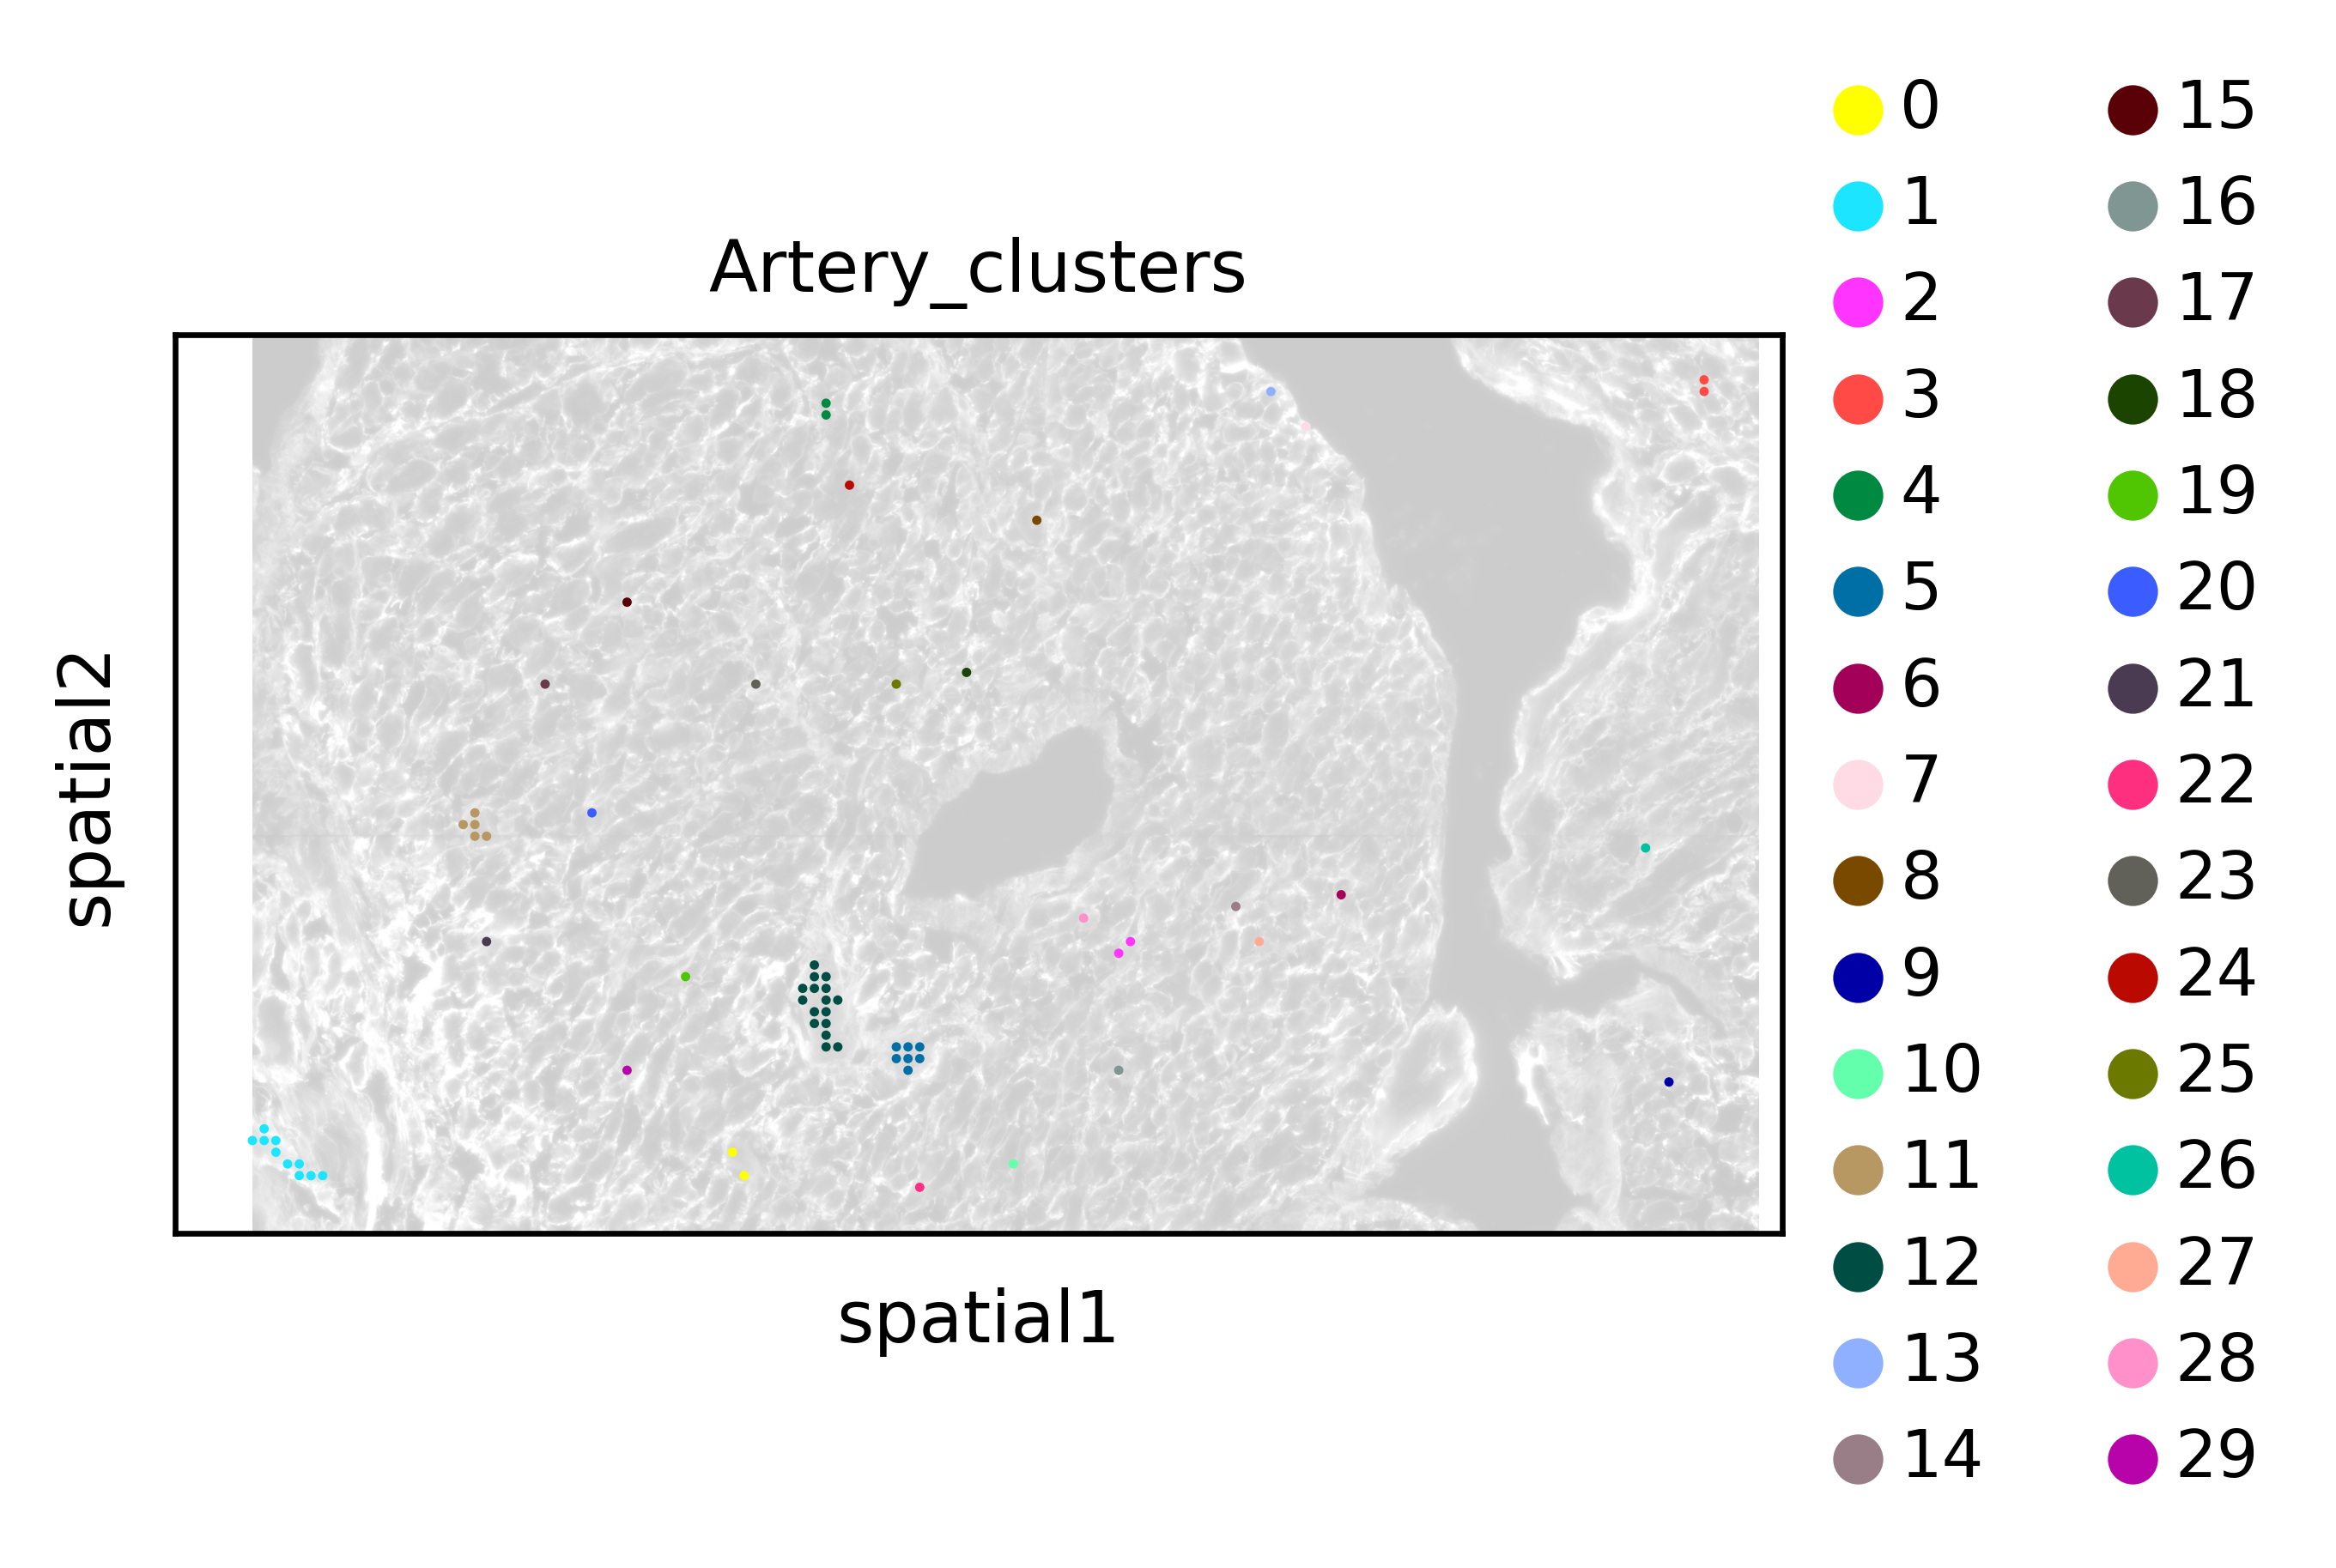

In [56]:
sc.pl.spatial(adata_aec,color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

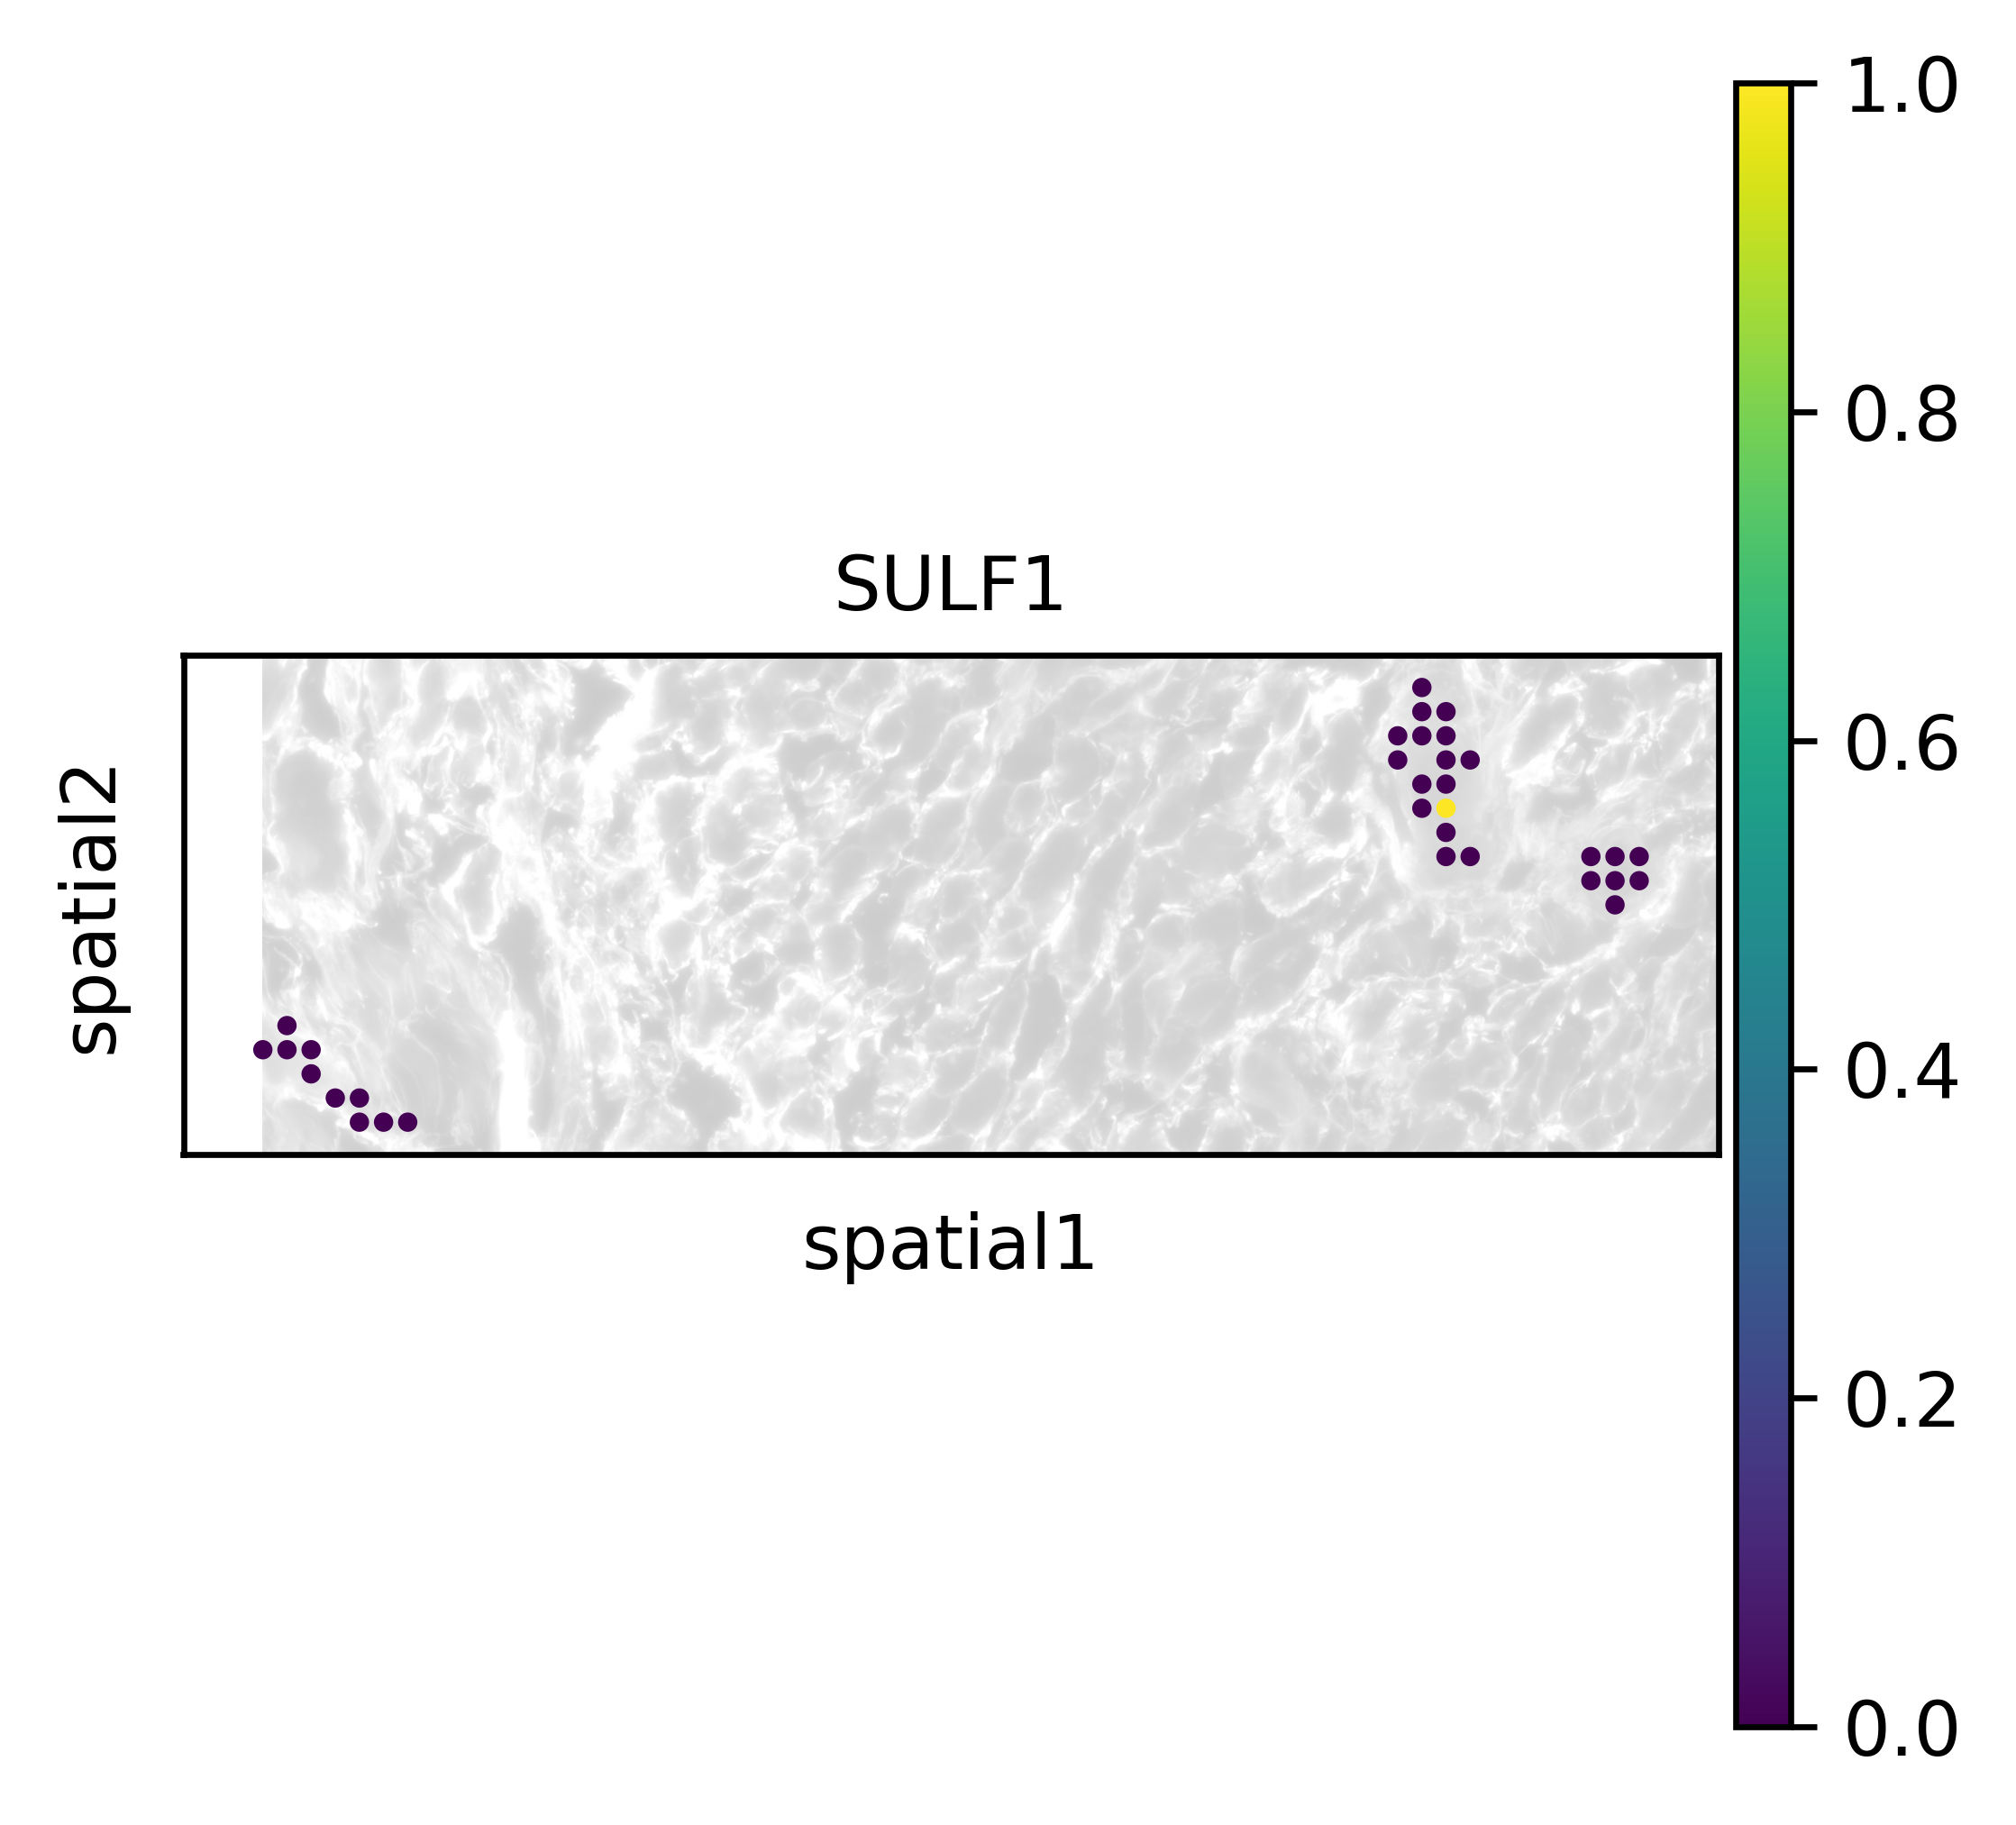

In [57]:
sc.pl.spatial(adata_aec_subset,color="SULF1",img_key='WGA',size=8, alpha_img = 0.2, vmax = 1)

In [58]:
group=pd.Series("Large", index=results2.index)

In [59]:
group[results2["size"] <= 30] = "Small"

In [60]:
group

ROI_A1-1_1     Small
ROI_A1-1_12    Small
ROI_A1-1_5     Small
dtype: object

In [61]:
results2["group"] = group

In [62]:
results2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  SEMA3G_percent  \
ROI_A1-1_1                  0.0         0.0000      0.300000        0.500000   
ROI_A1-1_12                 0.0         0.0625      0.312500        0.812500   
ROI_A1-1_5                  0.0         0.0000      0.428571        0.714286   

             RGCC_percent  SULF1  NEBL    SEMA3G  RGCC  size   ROI  group  
ROI_A1-1_1         0.5000    NaN   1.0  2.200000   1.4    10  A1-1  Small  
ROI_A1-1_12        0.1875    1.0   1.2  2.384615   1.0    16  A1-1  Small  
ROI_A1-1_5         0.0000    NaN   1.0  2.000000   NaN     7  A1-1  Small

In [63]:
#results2.drop(["ROI_A1-1_1"])

In [64]:
### calculate mean / group

In [65]:
results2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  SEMA3G_percent  \
ROI_A1-1_1                  0.0         0.0000      0.300000        0.500000   
ROI_A1-1_12                 0.0         0.0625      0.312500        0.812500   
ROI_A1-1_5                  0.0         0.0000      0.428571        0.714286   

             RGCC_percent  SULF1  NEBL    SEMA3G  RGCC  size   ROI  group  
ROI_A1-1_1         0.5000    NaN   1.0  2.200000   1.4    10  A1-1  Small  
ROI_A1-1_12        0.1875    1.0   1.2  2.384615   1.0    16  A1-1  Small  
ROI_A1-1_5         0.0000    NaN   1.0  2.000000   NaN     7  A1-1  Small

In [66]:
results2.to_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/A1-1.csv")